<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [114]:
!pip install --upgrade --no-cache-dir gdown --quiet

/bin/bash: /home/juaniribet/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

2023-09-28 13:16:34.220646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 13:16:40.297764: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [116]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [4]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [5]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
print(df_reviews.shape)
df_reviews.groupby(by=['Rating']).count()

(22641, 2)


,Review Text
Rating,
0,821
1,1549
2,2823
3,4908
4,12540


In [6]:
def plot_weigth_balance(df):
    '''
    Función para graficar el balance de calses con sus porcentajes
    '''
    # Calcular counts y porcentajes
    valid_categories = df
    category_counts = valid_categories.value_counts()
    total_count = len(valid_categories)
    category_percentages = (category_counts / total_count) * 100

    # Grafico
    plt.figure(figsize=(10, 6))
    bars = plt.bar(category_counts.index, category_counts)
    plt.xlabel("Rating")
    plt.ylabel("Review Text")
    plt.bar_label(bars, label_type='center')

    # Agregar porcentajes sobre las barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        category = category_counts.index[i]
        if category in category_percentages:
            percentage = category_percentages[category]
            plt.text(bar.get_x() + bar.get_width() / 2, height, f"{percentage:.2f}%", ha="center", va="bottom")
            

    plt.show()

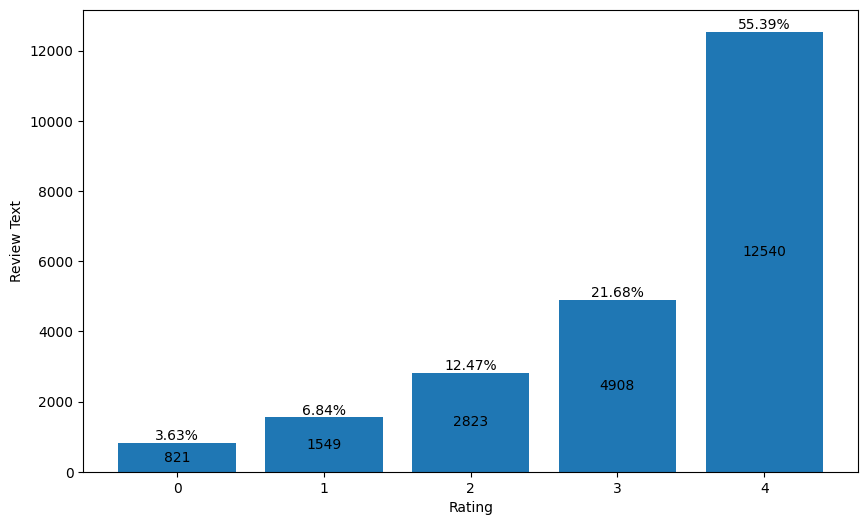

In [7]:
plot_weigth_balance(df_reviews['Rating'])

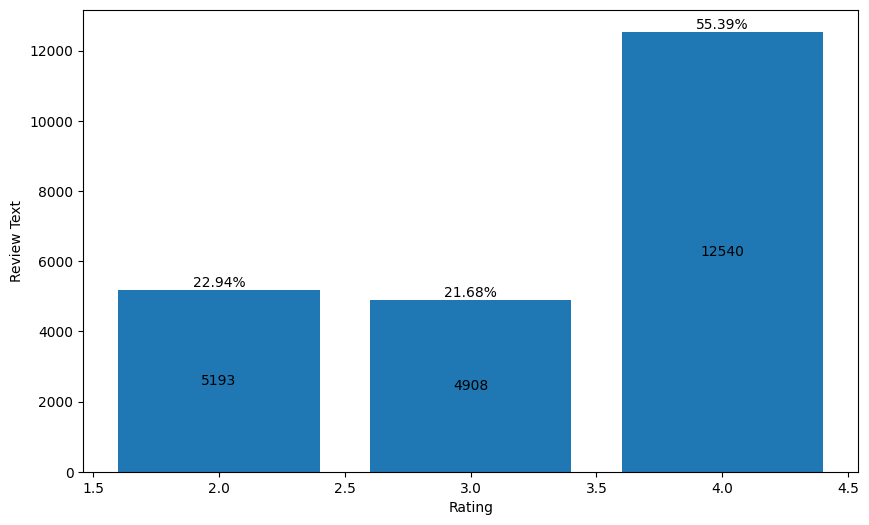

In [8]:
# Unificacion de los 'Rating' 0, 1 y 2 en 2
df_reviews['Rating'] = df_reviews['Rating'].replace({0: 2, 1: 2})
plot_weigth_balance(df_reviews['Rating'])

In [9]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [10]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [11]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [12]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [13]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [14]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [15]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [16]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [17]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
print(f'tamaño de vocabulario : {len(word_index)}')
index_word = tok.index_word
print(index_word)

tamaño de vocabulario : 14847
{1: 'the', 2: 'i', 3: 'and', 4: 'a', 5: 'it', 6: 'is', 7: 'this', 8: 'to', 9: 'in', 10: 'but', 11: 'on', 12: 'for', 13: 'of', 14: 'with', 15: 'was', 16: 'so', 17: 'my', 18: 'dress', 19: 'not', 20: 'that', 21: 'love', 22: 'size', 23: 'very', 24: 'have', 25: 'top', 26: 'fit', 27: 'are', 28: 'like', 29: 'be', 30: 'as', 31: 'me', 32: 'wear', 33: "it's", 34: 'great', 35: 'too', 36: "i'm", 37: 'or', 38: 'am', 39: 'just', 40: 'you', 41: 'would', 42: 'they', 43: 'up', 44: 'at', 45: 'fabric', 46: 'small', 47: 'color', 48: 'look', 49: 'if', 50: 'more', 51: 'really', 52: 'ordered', 53: 'little', 54: 'perfect', 55: 'will', 56: 'one', 57: 'these', 58: 'flattering', 59: 'well', 60: 'an', 61: 'soft', 62: 'out', 63: 'back', 64: 'because', 65: 'had', 66: 'can', 67: '\r', 68: 'comfortable', 69: 'cute', 70: 'nice', 71: 'than', 72: 'bought', 73: 'beautiful', 74: 'when', 75: 'all', 76: 'looks', 77: 'bit', 78: 'fits', 79: 'large', 80: 'shirt', 81: 'down', 82: 'which', 83: 'mate

In [18]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [19]:
# Alumno: Determinar cual es la oración más larga
seqs_lenght = [len(s) for s in sequences]
print(f'el máximo es {max(seqs_lenght)}')

el máximo es 115


(array([ 21.,  15.,  26.,  22.,  39.,  54.,  78., 293., 147., 132., 189.,
        168., 195., 188., 180., 389., 204., 227., 225., 229., 240., 227.,
        254., 504., 249., 265., 243., 289., 238., 257., 503., 262., 278.,
        268., 287., 306., 258., 243., 494., 269., 252., 227., 266., 230.,
        229., 243., 506., 257., 231., 224., 236., 231., 229., 464., 212.,
        222., 220., 223., 204., 195., 195., 399., 171., 200., 197., 171.,
        186., 191., 178., 412., 206., 215., 244., 201., 255., 287., 600.,
        317., 350., 368., 367., 390., 346., 313., 639., 247., 246., 194.,
        144., 113.,  71.,  50.,  75.,  20.,   7.,  12.,   2.,   4.,   1.,
          1.]),
 array([  2.  ,   3.13,   4.26,   5.39,   6.52,   7.65,   8.78,   9.91,
         11.04,  12.17,  13.3 ,  14.43,  15.56,  16.69,  17.82,  18.95,
         20.08,  21.21,  22.34,  23.47,  24.6 ,  25.73,  26.86,  27.99,
         29.12,  30.25,  31.38,  32.51,  33.64,  34.77,  35.9 ,  37.03,
         38.16,  39.29,  40.42

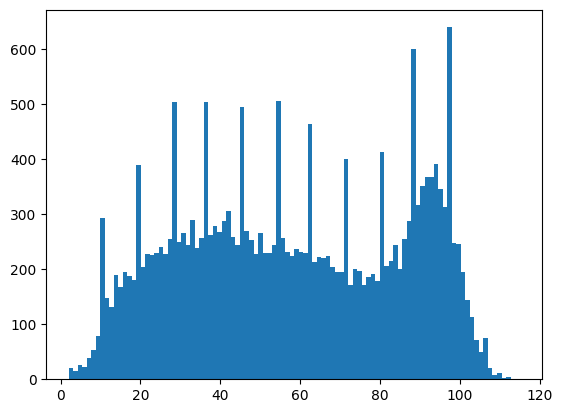

In [20]:
# y también explorar cómo es la distribución de tamaños de secuencias
plt.figure()
plt.hist(seqs_lenght,bins=100)

In [21]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [22]:
# qué porcentaje de los datos se procesan completamente
(np.array(seqs_lenght)<maxlen).mean()

0.999955832339561

In [23]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [24]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 3 luego de la unificaión)
y = df_reviews['Rating']
y = pd.get_dummies(y, columns=['Rating'], dtype=int)
print(y.shape)
y.head(5)

(22641, 3)


,2,3,4
0,0,1,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1


In [25]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
print('X_train: ' , X_train.shape)
print('X_test: ' , X_test.shape)
print('y_train: ' , y_train.shape)
print('y_test: ' , y_test.shape)

X_train:  (18112, 115)
X_test:  (4529, 115)
y_train:  (18112, 3)
y_test:  (4529, 3)


In [29]:
# Duplico los valores del set de entrenamiento para las clases 2 y 3 y asi tener un mejor balance
df_train_dp = np.concatenate((X_train, y_train), axis=1)
df_train_dp = np.delete(df_train_dp, np.where(df_train_dp[:,-1:] == 1), axis=0)
np.random.shuffle(df_train_dp)
df_train_dp.shape

X_train_dp = df_train_dp[:,:-3].copy()
y_train_dp = df_train_dp[:,-3:].copy()

X_train = np.concatenate((X_train, X_train_dp), axis=0)
y_train = np.concatenate((y_train, y_train_dp), axis=0)


print('X_train: ' , X_train.shape)
print('X_test: ' , X_test.shape)
print('y_train: ' , y_train.shape)
print('y_test: ' , y_test.shape)

X_train:  (26228, 115)
X_test:  (4529, 115)
y_train:  (26228, 3)
y_test:  (4529, 3)


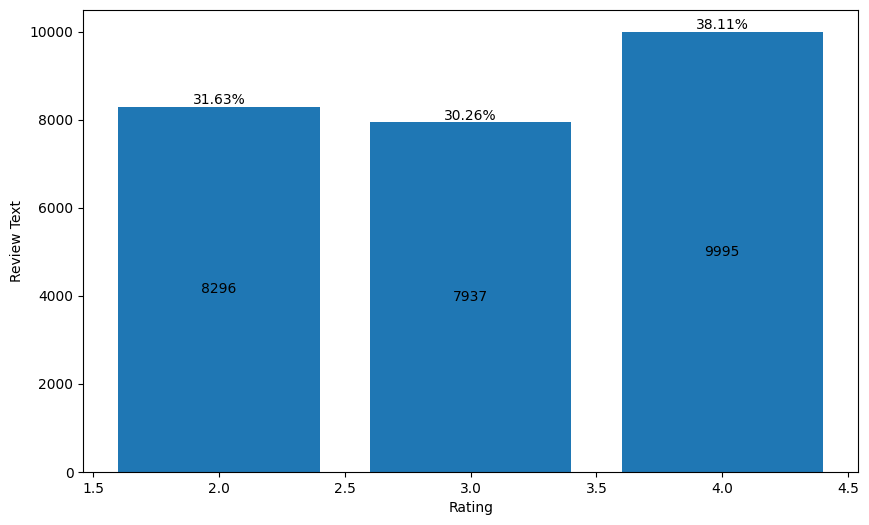

In [30]:
# Verifico el balance del set de entrenamiento
y_train1 = y_train.copy()
y_train1[:,:1] = np.where(y_train1[:,:1] == 1 , 2, 0)
y_train1[:,1:2] = np.where(y_train1[:,1:2] == 1 , 3, 0)
y_train1[:,2:3] = np.where(y_train1[:,2:3] == 1 , 4, 0)
y_train1 = y_train1[:,:1] + y_train1[:,1:2] + y_train1[:,2:3]
y_train1 = pd.DataFrame(y_train1, columns=['Rating'])
plot_weigth_balance(y_train1['Rating'])

In [31]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 3 # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 3


### 2 - Entrenar el modelo con Embeddings + LSTM

In [32]:
# Entrenar un modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 115
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()])

model.summary()

2023-09-28 13:17:07.060522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-28 13:17:07.781242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-28 13:17:07.781360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-28 13:17:07.784854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-28 13:17:07.785002: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 50)           100050    
                                                                 
 lstm (LSTM)                 (None, 115, 128)          91648     
                                                                 
 dropout (Dropout)           (None, 115, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 115, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 115, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 128)               8

In [50]:
hist = model.fit(X_train, y_train, epochs=60, validation_split=0.2)

Epoch 1/60
656/656 [==============================] - 59s 89ms/step - loss: 0.0598 - precision: 0.9729 - recall: 0.9667 - val_loss: 0.0944 - val_precision: 0.9579 - val_recall: 0.9495
Epoch 2/60
656/656 [==============================] - 55s 84ms/step - loss: 0.0507 - precision: 0.9774 - recall: 0.9731 - val_loss: 0.0527 - val_precision: 0.9774 - val_recall: 0.9718
Epoch 3/60
656/656 [==============================] - 53s 81ms/step - loss: 0.0460 - precision: 0.9794 - recall: 0.9753 - val_loss: 0.0776 - val_precision: 0.9634 - val_recall: 0.9539
Epoch 4/60
656/656 [==============================] - 53s 81ms/step - loss: 0.0485 - precision: 0.9782 - recall: 0.9737 - val_loss: 0.0445 - val_precision: 0.9804 - val_recall: 0.9735
Epoch 5/60
656/656 [==============================] - 51s 78ms/step - loss: 0.0507 - precision: 0.9761 - recall: 0.9722 - val_loss: 0.0584 - val_precision: 0.9696 - val_recall: 0.9659
Epoch 6/60
656/656 [==============================] - 55s 84ms/step - loss: 0.04

/home/juaniribet/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juaniribet/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juaniribet/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/juaniribet/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

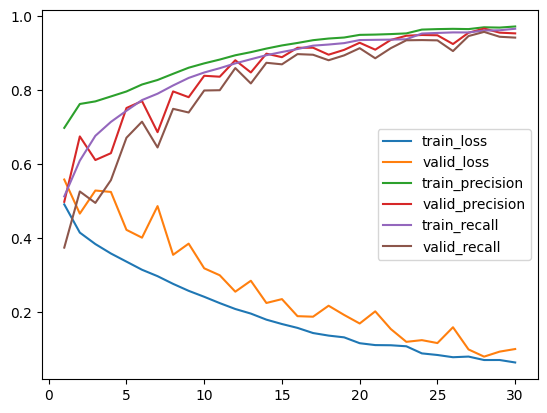

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history[list(hist.history.keys())[0]]) + 1)
sns.lineplot(x=epoch_count,  y=hist.history[list(hist.history.keys())[0]], label='train_loss')
sns.lineplot(x=epoch_count,  y=hist.history[list(hist.history.keys())[3]], label='valid_loss')
sns.lineplot(x=epoch_count,  y=hist.history[list(hist.history.keys())[1]], label='train_precision')
sns.lineplot(x=epoch_count,  y=hist.history[list(hist.history.keys())[4]], label='valid_precision')
sns.lineplot(x=epoch_count,  y=hist.history[list(hist.history.keys())[2]], label='train_recall')
sns.lineplot(x=epoch_count,  y=hist.history[list(hist.history.keys())[5]], label='valid_recall')
plt.show()

In [52]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 5s 33ms/step - loss: 1.6107 - precision: 0.6563 - recall: 0.6527


[1.6106507778167725, 0.6563054919242859, 0.6526827216148376]